In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from ast import literal_eval

# Import necessary modules
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score 
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

In [2]:
#Load train document
train=pd.read_csv('data/train_clean.csv', na_values='Unknown')
print(train.head())

                                           msno  \
0  FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=   
1  Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=   
2  Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=   
3  Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=   
4  FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=   

                                        song_id source_system_tab  \
0  BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=           explore   
1  bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=        my library   
2  JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=        my library   
3  2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=        my library   
4  3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=           explore   

    source_screen_name      source_type  target  
0              explore  online-playlist       1  
1  local playlist more   local-playlist       1  
2  local playlist more   local-playlist       1  
3  local playlist more   local-playlist       1  
4              explore  onli

In [3]:
#Check amount of NaN in train.csv by column
train.isnull().sum()

msno                       0
song_id                    0
source_system_tab          0
source_screen_name    444107
source_type                0
target                     0
dtype: int64

In [4]:
train.shape

(7349234, 6)

In [5]:
# Replace Nan by -1
train=train.fillna(-1)

# Convert variables to category
for item in ['source_system_tab','source_screen_name','source_type']:
    train[item]=train[item].astype('category')

In [6]:
#Compute total unique songs listened by user
users_total_songs=train.groupby('msno').msno.count().to_frame()
users_total_songs.columns=['song_count']
users_total_songs.head()

# Join songs count to train data
train=pd.merge(train,users_total_songs,left_on='msno',right_index=True)
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_count
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,explore,online-playlist,1,5511
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,explore,online-playlist,1,5511
5,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3Hg5kugV1S0wzEVLAEfqjIV5UHzb7bCrdBRQlGygLvU=,explore,explore,online-playlist,1,5511
7,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,bPIvRTzfHxH5LgHrStll+tYwSQNVV8PySgA3M1PfTgc=,explore,explore,online-playlist,1,5511
6707,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,XUz4Z4wPPChz+OIwkwj7HJ8teIjW3rEMdEATM80rDxM=,explore,explore,online-playlist,1,5511


In an attempt to sub-sample the dataset to reduce the volumen, we will check if there are many users who have listened few songs so we can just keep the users with higher number of songs listened. This will increase the possibilities to find these users both in the train and test samples after splitting the data.

In [7]:
train_sample=train[train.song_count<=10]
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18738 entries, 609 to 7349075
Data columns (total 7 columns):
msno                  18738 non-null object
song_id               18738 non-null object
source_system_tab     18738 non-null object
source_screen_name    18738 non-null object
source_type           18738 non-null object
target                18738 non-null int64
song_count            18738 non-null int64
dtypes: int64(2), object(5)
memory usage: 1.1+ MB


In [8]:
train_sample=train[train.song_count<=20]
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51569 entries, 293 to 7349075
Data columns (total 7 columns):
msno                  51569 non-null object
song_id               51569 non-null object
source_system_tab     51569 non-null object
source_screen_name    51569 non-null object
source_type           51569 non-null object
target                51569 non-null int64
song_count            51569 non-null int64
dtypes: int64(2), object(5)
memory usage: 3.1+ MB


Users with low number of songs don't represent a big proportion of the data. Therefore we will segment users who have listen between 20 to 30 songs as a subsample.

In [9]:
train_sample=train[(train.song_count>=20) & (train.song_count<30)]
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37717 entries, 689 to 7347549
Data columns (total 7 columns):
msno                  37717 non-null object
song_id               37717 non-null object
source_system_tab     37717 non-null object
source_screen_name    37717 non-null object
source_type           37717 non-null object
target                37717 non-null int64
song_count            37717 non-null int64
dtypes: int64(2), object(5)
memory usage: 2.3+ MB


In [10]:
#Check amount of NaN in train.csv by column
train_sample.isnull().sum()

msno                  0
song_id               0
source_system_tab     0
source_screen_name    0
source_type           0
target                0
song_count            0
dtype: int64

In [11]:
# Generate dummy variables in members
train_dummies=pd.get_dummies(train_sample[['source_system_tab','source_screen_name','source_type']],drop_first=True)

# Concatenate dummy variables and target varibale
df_train=pd.concat([train_sample[['target','msno','song_id']], train_dummies],axis=1)
df_train.head()

# Define df
df=df_train

# Define matrix values (X) and outcome variable (y)
X=df.drop(['target','msno', 'song_id'],axis=1).values
y=df.target.values

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42, stratify=y)

In [12]:
def roc_curve_plot(model,X_test,y_test):

    # Compute predicted probabilities: y_pred_prob
    y_pred_prob = model.predict_proba(X_test)[:,1]

    # Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

{'C': 0.1}
Accuracy score:  0.664899257688
ROC-AUC score:  0.527724853646


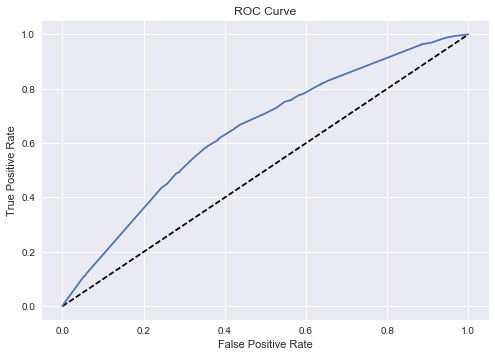

In [13]:
# Setup the hyperparameter grid
Cs = [0.001, 0.1, 1, 10, 100]
param_grid = {'C': Cs}

# Create a logistic regression classifier: clf
clf=LogisticRegression()

# Create the Grid search object
logreg_cv=GridSearchCV(clf, param_grid, cv=5)

# Fit the model
logreg_cv.fit(X_train,y_train)

# Print best parameters
print(logreg_cv.best_params_)

# Print the accuracy and roc auc scores of the testing data
print('Accuracy score: ',accuracy_score(logreg_cv.predict(X_test),y_test))
print('ROC-AUC score: ',roc_auc_score(y_test,logreg_cv.predict(X_test)))

# Print roc curve
roc_curve_plot(logreg_cv,X_test,y_test)

In [14]:
# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
        ('svm', LinearSVC())]

# Setup the hyperparameter grid
param_grid = {'svm__C': [0.001, 0.1, 1, 10, 100]}

# Create the pipeline: pipeline
pipeline= Pipeline(steps)

# Create the Grid search object
svm_cv=GridSearchCV(pipeline, param_grid, cv=5)

# Fit the pipeline to the training set: svm_scaled
svm_cv.fit(X_train,y_train)

# Print best parameters
print(svm_cv.best_params_)

# Print the accuracy and roc auc scores of the testing data
print('Accuracy score: {}'.format(svm_cv.score(X_test,y_test)))
print('ROC-AUC score: ',roc_auc_score(y_test,svm_cv.predict(X_test)))

/Users/anavillalba/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/Users/anavillalba/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/Users/anavillalba/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/Users/anavillalba/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/Users/anavillalba/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:

{'svm__C': 0.001}
Accuracy score: 0.6644574054436196
ROC-AUC score:  0.52758739251


{'max_depth': 18}
Accuracy score: 0.6673736302580418
ROC-AUC score:  0.535182207781


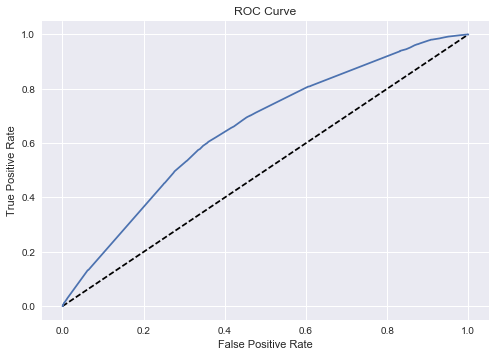

In [15]:
# Instantiate model
tree = DecisionTreeClassifier(random_state=42)

# Setup the hyperparameter grid
param_grid = {'max_depth': np.arange(3, 50)}

# Create the Grid search object
tree_cv=GridSearchCV(tree, param_grid, cv=5)

# Train the model on training data
tree_cv.fit(X_train,y_train)

# Print best parameters
print(tree_cv.best_params_)

# Print the accuracy and roc auc scores of the testing data
print('Accuracy score: {}'.format(accuracy_score(y_test,tree_cv.predict(X_test))))
print('ROC-AUC score: ',roc_auc_score(y_test,tree_cv.predict(X_test)))

# Print roc curve
roc_curve_plot(tree_cv,X_test,y_test)

In [16]:
# Instantiate model
rf = RandomForestRegressor(max_features='sqrt', random_state = 42)

# Train the model on training data
#rf.fit(X_train, y_train)

# Setup the hyperparameter grid
param_grid = {'n_estimators': [10,100,1000]}

# Create the Grid search object
rf_cv=GridSearchCV(rf, param_grid, cv=5)

# Train the model on training data
rf_cv.fit(X_train, y_train)

# Print best parameters
print(rf_cv.best_params_)


# Print the accuracy and roc auc scores of the testing data
#print('Accuracy score: {}'.format(accuracy_score(y_test,rf_cv.predict(X_test))))
print('ROC-AUC score: ',roc_auc_score(y_test,rf_cv.predict(X_test)))

{'n_estimators': 1000}
ROC-AUC score:  0.654496617742


In [17]:
# Compute scores using cross validation
#cv_scores = cross_val_score(rf, X_train, y_train, cv=5)
#cv_auc = cross_val_score(rf,X_train, y_train, cv=5, scoring='roc_auc')

# Print the accuracy of the testing data
#print('Accuracy score: {}'.format(cv_scores.mean()))
#print('ROC-AUC score: {}'.format(cv_auc.mean()))

### Including members features

- We are evaluating still the subsample with users who have listened between 20 and 30 different songs.
- We will now include more features to try to improve performance.

In [18]:
#Load members document
members=pd.read_csv('data/members_clean.csv', na_values='Unknown')
print(members.head())

# Fill gender Nan values with -1
members.gender=members.gender.fillna(-1)

# Fill missing age values with most frequent value
members.bd=members.bd.fillna(members.bd.value_counts().index[0])

# Transform to categorical variables
for item in ['city','gender','registered_via']:
    members[item]=members[item].astype('category')
    
for item in ['registration_init_time','expiration_date']:
    members[item]=pd.to_datetime(members[item],format='%Y-%m-%d')
    
# Compute new column days from registration to expiration
members['days_from_reg_to_exp']=members.apply(lambda row: (row.expiration_date - row.registration_init_time).days, axis=1)

                                           msno  city  bd gender  \
0  XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=     1 NaN    NaN   
1  UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=     1 NaN    NaN   
2  D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=     1 NaN    NaN   
3  mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=     1 NaN    NaN   
4  q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=     1 NaN    NaN   

   registered_via registration_init_time expiration_date  
0               7             2011-08-20      2017-09-20  
1               7             2015-06-28      2017-06-22  
2               4             2016-04-11      2017-07-12  
3               9             2015-09-06      2015-09-07  
4               4             2017-01-26      2017-06-13  


In [19]:
#Check amount of NaN in members_clean.csv by column
members.info()

# Generate dummy variables in members
members_dummies=pd.get_dummies(members[['city','bd','gender','registered_via','days_from_reg_to_exp']],drop_first=True)

# Join msno column and dummy variables in members
df_members=pd.concat([members.msno, members_dummies],axis=1)

# Join df_members with train data
df=df_train.merge(df_members, on='msno', how='left')

# Define matrix values (X) and outcome variable (y)
X=df.drop(['target','msno', 'song_id'],axis=1).values
y=df.target.values

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42, stratify=y)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34402 entries, 0 to 34401
Data columns (total 8 columns):
msno                      34402 non-null object
city                      34402 non-null category
bd                        34402 non-null float64
gender                    34402 non-null category
registered_via            34402 non-null category
registration_init_time    34402 non-null datetime64[ns]
expiration_date           34402 non-null datetime64[ns]
days_from_reg_to_exp      34402 non-null int64
dtypes: category(3), datetime64[ns](2), float64(1), int64(1), object(1)
memory usage: 1.4+ MB


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37717 entries, 0 to 37716
Data columns (total 68 columns):
target                                     37717 non-null int64
msno                                       37717 non-null object
song_id                                    37717 non-null object
source_system_tab_explore                  37717 non-null uint8
source_system_tab_listen with              37717 non-null uint8
source_system_tab_my library               37717 non-null uint8
source_system_tab_notification             37717 non-null uint8
source_system_tab_radio                    37717 non-null uint8
source_system_tab_search                   37717 non-null uint8
source_system_tab_settings                 37717 non-null uint8
source_screen_name_album more              37717 non-null uint8
source_screen_name_artist more             37717 non-null uint8
source_screen_name_concert                 37717 non-null uint8
source_screen_name_discover chart          37717 non-null

In [21]:
X.shape

(37717, 65)

{'C': 1}
Accuracy score:  0.667373630258
ROC-AUC score:  0.527375703762


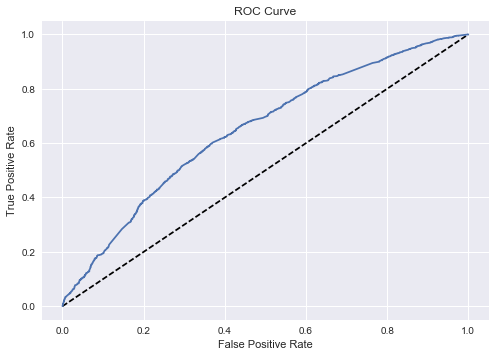

In [22]:
# Setup the hyperparameter grid
Cs = [0.001, 0.1, 1, 10, 100]
param_grid = {'C': Cs}

# Create a logistic regression classifier: clf
clf=LogisticRegression()

# Create the Grid search object
logreg_cv=GridSearchCV(clf, param_grid, cv=5)

# Fit the model
logreg_cv.fit(X_train,y_train)

# Print best parameters
print(logreg_cv.best_params_)

# Print the accuracy and roc auc scores of the testing data
print('Accuracy score: ',accuracy_score(logreg_cv.predict(X_test),y_test))
print('ROC-AUC score: ',roc_auc_score(y_test,logreg_cv.predict(X_test)))

# Print roc curve
roc_curve_plot(logreg_cv,X_test,y_test)

In [23]:
# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
        ('svm', LinearSVC())]

# Setup the hyperparameter grid
param_grid = {'svm__C': [0.001, 0.1, 1, 10, 100]}

# Create the pipeline: pipeline
pipeline= Pipeline(steps)

# Create the Grid search object
svm_cv=GridSearchCV(pipeline, param_grid, cv=5)

# Fit the pipeline to the training set: svm_scaled
svm_cv.fit(X_train,y_train)

# Print best parameters
print(svm_cv.best_params_)

# Print the accuracy and roc auc scores of the testing data
print('Accuracy score: {}'.format(svm_cv.score(X_test,y_test)))
print('ROC-AUC score: ',roc_auc_score(y_test,svm_cv.predict(X_test)))

{'svm__C': 0.1}
Accuracy score: 0.6643690349946978
ROC-AUC score:  0.522902019551


{'max_depth': 31}
Accuracy score: 0.7528278543655001
ROC-AUC score:  0.681610038934


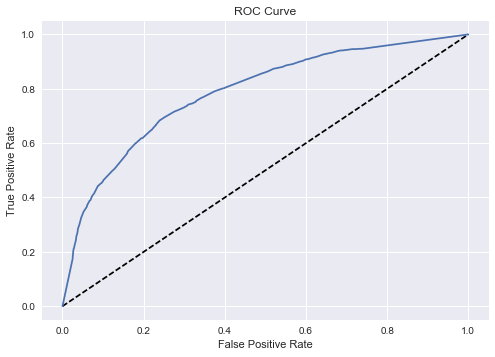

In [24]:
# Instantiate model
tree = DecisionTreeClassifier(random_state=42)

# Setup the hyperparameter grid
param_grid = {'max_depth': np.arange(3, 50)}

# Create the Grid search object
tree_cv=GridSearchCV(tree, param_grid, cv=5)

# Train the model on training data
tree_cv.fit(X_train,y_train)

# Print best parameters
print(tree_cv.best_params_)

# Print the accuracy and roc auc scores of the testing data
print('Accuracy score: {}'.format(accuracy_score(y_test,tree_cv.predict(X_test))))
print('ROC-AUC score: ',roc_auc_score(y_test,tree_cv.predict(X_test)))

# Print roc curve
roc_curve_plot(tree_cv,X_test,y_test)

In [25]:
# Instantiate model
rf = RandomForestRegressor(max_features='sqrt', random_state = 42)

# Setup the hyperparameter grid
param_grid = {'n_estimators': [10,100,1000]}

# Create the Grid search object
rf_cv=GridSearchCV(rf, param_grid, cv=5)

# Train the model on training data
rf_cv.fit(X_train, y_train)

# Print best parameters
print(rf_cv.best_params_)

# Print the accuracy and roc auc scores of the testing data
#print('Accuracy score: {}'.format(accuracy_score(y_test,rf_cv.predict(X_test))))
print('ROC-AUC score: ',roc_auc_score(y_test,rf_cv.predict(X_test)))

{'n_estimators': 100}
ROC-AUC score:  0.796493463068


In the initial analysis only taking into account only train features, we did not see much difference in performace between the different methods. 

In this second analysis where we are also including members features, we are observing an gradual improvement going from logistic regression (roc-auc: 0.6674) to tree classifier (roc-auc: 0.6816) to random forest (roc-auc: 0.7965). 

### Including songs features

- We are evaluating still the subsample with users who have listened between 20 and 30 different songs.
- We will now include song features to try to improve performance.
- We will just do transformation on the songs that are within the subsample to reduce analysis complexity.

In [26]:
#Load train document
songs=pd.read_csv('data/songs_clean.csv', na_values='Unknown')
print(songs.head())

# We will just do transfo
song_sample=songs.merge(train_sample[['song_id']], on='song_id')

# Display info about the song_sample
song_sample.head()
song_sample.info()

                                        song_id  song_length_min genre_ids  \
0  CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=         4.127333   ['465']   
1  o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=         3.288800   ['444']   
2  DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=         3.863017   ['465']   
3  dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=         4.559233   ['465']   
4  W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=         2.338817   ['726']   

        artist_name                                  composer  \
0  張信哲 (Jeff Chang)                                    ['董貞']   
1         Blackpink  ['Teddy', 'Future Bounce', 'Bekuh Boom']   
2      Super Junior                                       NaN   
3             S.H.E                                   ['湯小康']   
4              貴族精選                           ['Traditional']   

          lyricist  language  genre_count  
0          ['何啟弘']         3          1.0  
1        ['Teddy']        31          1.0  
2       

In [27]:
# Replace Nan by list with -1
for item in ['genre_ids','composer','lyricist']:
    song_sample[item]=song_sample[item].apply(lambda x: literal_eval(x) if np.all(pd.notnull(x)) else ['-1'])
    
# Fill artist_name Nan values with -1
song_sample.artist_name=song_sample.artist_name.fillna(-1)

# Convert language into categorical variable
song_sample['language']=song_sample['language'].astype('category')

# Set up MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Get dummies for genre_ids and composer columns (separate items in list)
genre_ids_dummies=pd.DataFrame(mlb.fit_transform(song_sample.genre_ids),columns=mlb.classes_, index=song_sample.index)
composer_dummies=pd.DataFrame(mlb.fit_transform(song_sample.composer),columns=mlb.classes_, index=song_sample.index)
#lyricist_dummies=pd.DataFrame(mlb.fit_transform(song_sample.lyricist),columns=mlb.classes_, index=song_sample.index)

# Drop first column from genre_ids, composer and lyricist dummy variables
for item in [genre_ids_dummies,composer_dummies]:
    item = item.drop(item.columns[0],axis=1)

# Generate dummy variables in songs
songs_dummies=pd.get_dummies(song_sample[['song_length_min','language']],drop_first=True)

#df_songs=pd.concat([songs[['song_id']],songs_dummies, genre_ids_dummies, composer_dummies],axis=1)
df_songs=pd.concat([song_sample[['song_id']],songs_dummies, genre_ids_dummies],axis=1)

In [28]:
df_songs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37717 entries, 0 to 37716
Data columns (total 98 columns):
song_id            37717 non-null object
song_length_min    37717 non-null float64
language_3         37717 non-null uint8
language_10        37717 non-null uint8
language_17        37717 non-null uint8
language_24        37717 non-null uint8
language_31        37717 non-null uint8
language_38        37717 non-null uint8
language_45        37717 non-null uint8
language_52        37717 non-null uint8
language_59        37717 non-null uint8
-1                 37717 non-null int64
1011               37717 non-null int64
1019               37717 non-null int64
1026               37717 non-null int64
1040               37717 non-null int64
1082               37717 non-null int64
109                37717 non-null int64
1096               37717 non-null int64
1138               37717 non-null int64
1152               37717 non-null int64
1155               37717 non-null int64
118     

In [29]:
df=df.merge(df_songs, on='song_id', how='left')
df.head()

,target,msno,song_id,source_system_tab_explore,source_system_tab_listen with,source_system_tab_my library,source_system_tab_notification,source_system_tab_radio,source_system_tab_search,source_system_tab_settings,...,880,893,900,921,94,940,947,958,965,972
0,1,FTLG/3qKMWA3grsNYM70g2NI4Psyy6gZNCpBXxVX4l8=,KcQ4assZxaXsdizqxGjUSAY7CNc6+6hQzpVsjnWsShQ=,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,FTLG/3qKMWA3grsNYM70g2NI4Psyy6gZNCpBXxVX4l8=,KcQ4assZxaXsdizqxGjUSAY7CNc6+6hQzpVsjnWsShQ=,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,FTLG/3qKMWA3grsNYM70g2NI4Psyy6gZNCpBXxVX4l8=,KcQ4assZxaXsdizqxGjUSAY7CNc6+6hQzpVsjnWsShQ=,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,FTLG/3qKMWA3grsNYM70g2NI4Psyy6gZNCpBXxVX4l8=,KcQ4assZxaXsdizqxGjUSAY7CNc6+6hQzpVsjnWsShQ=,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,FTLG/3qKMWA3grsNYM70g2NI4Psyy6gZNCpBXxVX4l8=,KcQ4assZxaXsdizqxGjUSAY7CNc6+6hQzpVsjnWsShQ=,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37717 entries, 0 to 1375964
Columns: 165 entries, target to 972
dtypes: float64(2), int64(89), object(2), uint8(72)
memory usage: 29.6+ MB


In [40]:
# Define matrix values (X) and outcome variable (y)
X=df.drop(['target','msno', 'song_id'],axis=1).values
y=df.target.values

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42, stratify=y)

In [41]:
X.shape

(37717, 162)

{'max_depth': 20}
Accuracy score: 0.7127960410038883
ROC-AUC score:  0.646985588639


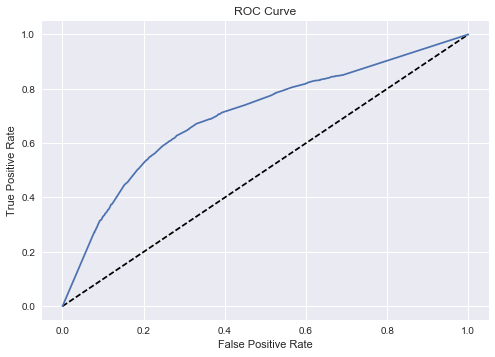

In [42]:
# Instantiate model
tree = DecisionTreeClassifier(random_state=42)

# Setup the hyperparameter grid
param_grid = {'max_depth': [10,20,30,40,50]}

# Create the Grid search object
tree_cv=GridSearchCV(tree, param_grid, cv=3)

# Train the model on training data
tree_cv.fit(X_train,y_train)

# Print best parameters
print(tree_cv.best_params_)

# Print the accuracy and roc auc scores of the testing data
print('Accuracy score: {}'.format(accuracy_score(y_test,tree_cv.predict(X_test))))
print('ROC-AUC score: ',roc_auc_score(y_test,tree_cv.predict(X_test)))

# Print roc curve
roc_curve_plot(tree_cv,X_test,y_test)

In [43]:
# Instantiate model
rf = RandomForestRegressor(n_estimators=100, max_features='sqrt', random_state = 42, n_jobs=-1)

# Train the model on training data
rf.fit(X_train, y_train)

# Print the accuracy and roc auc scores of the testing data
#print('Accuracy score: {}'.format(accuracy_score(y_test,rf_cv.predict(X_test))))
print('ROC-AUC score: ',roc_auc_score(y_test,rf.predict(X_test)))

ROC-AUC score:  0.75111798339


In [44]:
# Instantiate model
rf = RandomForestRegressor(max_features='sqrt', random_state = 42, n_jobs=-1)

# Setup the hyperparameter grid
param_grid = {'n_estimators': [10,100,1000]}

# Create the Grid search object
rf_cv=GridSearchCV(rf, param_grid, cv=3)

# Train the model on training data
rf_cv.fit(X_train, y_train)

# Print best parameters
print(rf_cv.best_params_)

# Print the accuracy and roc auc scores of the testing data
#print('Accuracy score: {}'.format(accuracy_score(y_test,rf_cv.predict(X_test))))
print('ROC-AUC score: ',roc_auc_score(y_test,rf_cv.predict(X_test)))

{'n_estimators': 1000}
ROC-AUC score:  0.752881852049


Adding information about the songs did not improve the performance of the model. We will try by doing dimension reduction with PCA to improve performance.

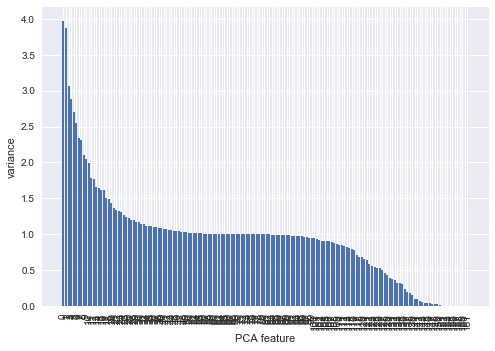

In [35]:
# Create scaler: scaler
scaler = StandardScaler()

# Create a PCA instance: pca
pca = PCA()

# Create pipeline: pipeline
pipeline = make_pipeline(scaler,pca)

# Fit the pipeline to 'samples'
pipeline.fit(X_train)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features,rotation=90)
plt.show()

In [36]:
# Build dataframe with explained variances
variance = pd.DataFrame({'Feature' : features,
 'Explained variance' : pca.explained_variance_})

# Print features with less than 0.5 of explained variance
variance[variance['Explained variance']<=0.5]

,Explained variance,Feature
128,4.655437e-01,128
129,4.280057e-01,129
130,3.835678e-01,130
131,3.689567e-01,131
132,3.577107e-01,132
133,3.183790e-01,133
134,3.141680e-01,134
135,3.025012e-01,135
136,2.368788e-01,136
137,1.945918e-01,137


Based on the previous PCA results, we should keep 128.

In [38]:
# Instantiate model
rf = RandomForestRegressor(n_estimators=100, max_features='sqrt', random_state = 42, n_jobs=-1)

# Create a PCA instance: pca
pca = PCA(n_components=128)

# Create pipeline: pipeline
pipeline = make_pipeline(scaler,pca,rf)

# Train the model on training data
pipeline.fit(X_train, y_train)

#X_test=scaler.transform(X_test)
#X_test=pca.transform(X_test)

# Print the accuracy and roc auc scores of the testing data
#print('Accuracy score: {}'.format(accuracy_score(y_test,rf_cv.predict(X_test))))
print('ROC-AUC score: ',roc_auc_score(y_test,pipeline.predict(X_test)))

ValueError: operands could not be broadcast together with shapes (11316,128) (162,) (11316,128) 

In [ ]:
# Define parameter spaces
n_components=[40,60,80,100,120]
n_estimators=[10,100,1000]

# Instantiate model
rf = RandomForestRegressor()

# Create a PCA instance: pca
pca = PCA()

# Create pipeline: pipeline
pipeline = make_pipeline(scaler,pca,rf)

# Setup the hyperparameter grid
params = {'pca__n_components': n_components, 'rf__n_estimators': n_estimators}

# Create the Grid search object
rf_pipeline_cv = GridSearchCV(pipeline, params, cv=3)

# Train the model on training data
rf_pipeline_cv.fit(X_train, y_train)

# Print best parameters
print(rf_pipeline_cv.best_params_)

# Print the accuracy and roc auc scores of the testing data
#print('Accuracy score: {}'.format(accuracy_score(y_test,rf_cv.predict(X_test))))
print('ROC-AUC score: ',roc_auc_score(y_test,rf_pipeline_cv.predict(X_test)))